# 前言
在银行借贷场景中，评分卡是一种以分数形式来衡量一个客户的信用风险大小的手段，它衡量向别人借钱的人（受信人，需要融资的公司）不能如期履行合同中的还本付息责任，并让借钱给别人的人（授信人，银行等金融机构）造成经济损失的可能性。**一般来说，评分卡打出的分数越高，客户的信用越好，风险越小**。如果这个人的风险太高，我们可以拒绝贷款。

本文以**个人消费类贷款数据**，简单介绍A评分卡的建模和制作流程。本文核心会在”**数据清洗**“和“**模型开发**”上。模型检验与评估也非常重要，内容太多，不再赘述。

# 1 导库，读取数据
在银行系统中，数据通常使来自于其他部门的同事的收集，因此千万别忘记抓住给你数据的人，问问她/他各个项都是什么含义。通常来说，当特征非常多的时候（比如几百个），都会有一个附带的excel或pdf文档给到你，备注了各个特征都是什么含义。这种情况下其实要一个个去看还是非常困难，所以如果特征很多，建议先做降维。

In [3]:
#其实日常在导库的时候，并不是一次性能够知道我们要用的所有库的。通常都是在建模过程中逐渐导入需要的库。
import numpy as np
import pandas as pd

data = pd.read_csv('./rankingcard.csv', index_col=0)  # index_col=0：将数据第一列作为行索引

# 2 探索数据与数据预处理
在这一步我们要样本总体的大概情况，比如查看缺失值，量纲是否统一，是否需要做哑变量等等。其实数据的探索和数据的预处理并不是完全分开的，并不一定非要先做哪一个，因此这个顺序只是供大家参考。

In [6]:
# 观察数据类型
data.head()

# 观察数据结构
data.shape  # (150000, 11)
data.info()  # "SeriousDlqin2yrs"为标签列 1代表坏客户

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

此处有图（说明各特征/标签含义）

## 2.1 去除重复值
现实数据，尤其是银行业数据，可能会存在的一个问题就是样本重复，即有超过一行的样本所显示的所有特征都一样。有时候可能是人为输入重复，有时候可能是系统录入重复，总而言之我们必须对数据进行去重处理。可能有人会说，难道不可能出现说两个样本的特征就是一模一样，但他们是两个样本吗？比如，两个人，一模一样的名字，年龄，性别，学历，工资……当特征量很少的时候，这的确是有可能的，但一些指标，比如说家属人数，月收入，已借有的房地产贷款数量等等，几乎不可能都出现一样。尤其是银行业数据经常是几百个特征，所有特征都一样的可能性是微乎其微的。即便真的出现了如此极端的情况，我们也可以当作是少量信息损失，将这条记录当作重复值除去。

In [7]:
# 去重 drop_duplicates
data.drop_duplicates(inplace=True)  # inplace表示在原数据上去重
data.info()

# 删除之后需要恢复正常的索引序列
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149391 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

## 2.2 填补缺失值

In [8]:
# 查看各列缺失情况
data.isnull().sum() / data.shape[0]
# data.isnull().mean() # 跟上面一样的结果

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

第二个要面临的问题，就是缺失值。在这里我们需要填补的特征是“收入”和“家属人数”。“家属人数”缺失很少，仅缺失了大约2.6%，可以考虑直接删除，或者使用均值来填补。“收入”缺失了几乎20%，并且我们知道，“收入”必然是一个对信用评分来说很重要的因素，因此这个特征必须要进行填补。在这里，我们使用均值填补“家属人数”。

In [9]:
data["NumberOfDependents"].fillna(int(data["NumberOfDependents"].mean()), inplace=True)  # 注意int()，因为家属人数是整数
# 如果选择的是删除缺失了2.6%的特征，记得恢复正常索引序列哦
# data.info()
data.isnull().sum() / data.shape[0]

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.000000
dtype: float64

那字段"收入"怎么办呢？对于银行数据来说，我们甚至可以有这样的推断：一个来借钱的人应该是会知道，“高收入”或者“稳定收入”于他/她自己而言会是申请贷款过程中的一个助力，因此如果收入稳定良好的人，肯定会倾向于写上自己的收入情况，那么这些“收入”栏缺失的人，更可能是收入状况不稳定或收入比较低的人。基于这种判断，我们可以用比如说，四分位数来填补缺失值，把所有收入为空的客户都当成是低收入人群。当然了，也有可能这些缺失是银行数据收集过程中的失误，我们并无法判断为什么收入栏会有缺失，所以我们的推断也有可能是不正确的。具体采用什么样的手段填补缺失值，要和业务人员去沟通，观察缺失值是如何产生的。在这里，我们使用随机森林填补“收入”。

**使用随机森林填补缺失值，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用**。相关内容可以见之前关于随机森林的文章。


In [10]:
def fill_missing_rf(X, y, tofill):
    """
        使用随机森林填补一个特征的缺失值的函数
        参数：
        X：要填补的特征矩阵
        y：完整的，没有缺失值的标签
        to_fill：字符串，要填补的那一列的名称
        返回对于需要填补的列中的缺失值的预测值
    """

    # 构建新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:, tofill]  # 要填补的那一列数据
    df = pd.concat([df.loc[:, df.columns != tofill], pd.DataFrame(y)], axis=1)

    # 找出训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index, :]
    Xtest = df.iloc[Ytest.index, :]

    # 使用随机森林回归填补缺失值
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)

    return Ypredict

接下来，我们来创造函数需要的参数，将参数导入函数，产出结果：

In [11]:
X = data.iloc[:, 1:]  # X为特征矩阵
y = data.iloc[:, 0]  # 注意第一列是我们原始数据的标签

y_pred = fill_missing_rf(X, y, "MonthlyIncome")

# 进行填补
data.loc[data.loc[:, "MonthlyIncome"].isnull(), "MonthlyIncome"] = y_pred

## 2.3 描述性统计处理缺失值
现实数据永远都会有一些异常值，首先我们要去把他们捕捉出来，然后观察他们的性质。注意，我们并不是要排除掉所有异常值，相反很多时候，异常值是我们的重点研究对象，比如说，双十一中购买量超高的品牌，或课堂上让很多学生都兴奋的课题，这些是我们要重点研究观察的。

日常处理异常值，我们使用箱线图或者3sigma法则来找到异常值（千万不要说依赖于眼睛看，除了业务理解，我们还要有方法）。但在银行数据中，我们希望排除的“异常值”不是一些超高或超低的数字，而是一些**不符合常理的数据**：比如，**收入不能为负数**，但是一个**超高水平的收入却是合理的**，可以存在的。所以在银行业中，我们往往就使用普通的描述性统计来观察数据的异常与否与数据的分布情况。注意，这种方法只能在特征量有限的情况下进行，如果有几百个特征又无法成功降维或特征选择不管用，那还是用3sigma比较好。

In [12]:
data.describe([0.01, 0.1, 0.25, .5, .75, .9, .99]).T

#异常值也被我们观察到，年龄的最小值居然有0，这不符合银行的业务需求，即便是儿童账户也要至少8岁，我们可以查看一下年龄为0的人有多少
(data.loc[:, "age"] == 0).sum()  # 1
#发现只有一个人年龄为0，可以判断这肯定是录入失误造成的，可以当成是缺失值来处理，直接删除掉这个样本
data = data[data["age"] != 0]

"""
另外，有三个指标看起来很奇怪：
"NumberOfTime30-59DaysPastDueNotWorse"
"NumberOfTime60-89DaysPastDueNotWorse"
"NumberOfTimes90DaysLate"
这三个指标分别是“过去两年内出现35-59天逾期但是没有发展的更坏的次数”，“过去两年内出现60-89天逾期但是没
有发展的更坏的次数”,“过去两年内出现90天逾期的次数”。这三个指标，在99%的分布的时候依然是2，最大值却是
98，看起来非常奇怪。一个人在过去两年内逾期35~59天98次，一年6个60天，两年内逾期98次这是怎么算出来的？
我们可以去咨询业务人员，请教他们这个逾期次数是如何计算的。如果这个指标是正常的，那这些两年内逾期了98次的
客户，应该都是坏客户。在我们无法询问他们情况下，我们查看一下有多少个样本存在这种异常：
"""
(data.loc[:, "NumberOfTimes90DaysLate"] > 90).sum()  # 225
#有225个样本存在这样的情况，并且这些样本，我们观察一下，标签并不都是1，他们并不都是坏客户。因此，我们基本可以判断，这些样本是某种异常，应该把它们删除。
data = data[data.loc[:, "NumberOfTimes90DaysLate"] < 90]
# 恢复索引
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149165 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149165 non-null  float64
 2   age                                   149165 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149165 non-null  int64  
 4   DebtRatio                             149165 non-null  float64
 5   MonthlyIncome                         149165 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149165 non-null  int64  
 7   NumberOfTimes90DaysLate               149165 non-null  int64  
 8   NumberRealEstateLoansOrLines          149165 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149165 non-null  int64  
 10  NumberOfDependents                    149165 non-null  float64
dtype

## 2.4 为什么不统一量纲，也不标准化数据分布？
在描述性统计结果中，我们可以观察到数据量纲明显不统一，而且存在一部分极偏的分布，虽然逻辑回归对于数据没有分布要求，但是我们知道如果数据服从正态分布的话梯度下降可以收敛得更快。但在这里，我们不对数据进行标准化处理，也不进行量纲统一，为什么？

无论算法有什么样的规定，无论统计学中有什么样的要求，我们的**最终目的都是要为业务服务**。现在我们要制作评分卡，评分卡是要给业务人员们使用的基于新客户填写的各种信息为客户打分的一张卡片，而为了制作这张卡片，我们需要对我们的数据进行一个“分档”，比如说，年龄20到30岁为一档，年龄30到50岁为一档，月收入1W以上为一档，5000到1W为一档，每档的分数不同。

一旦我们将数据统一量纲，或者标准化了之后，数据大小和范围都会改变，统计结果是漂亮了，但是对于业务人员来说，他们完全无法理解，标准化后的年龄在0.00328到0.00467之间为一档是什么含义。并且，新客户填写的信息，天生就是量纲不统一的，我们的确可以将所有的信息录入之后，统一进行标准化，然后导入算法计算，但是最终落到业务人员手上去判断的时候，他们会完全不理解为什么录入的信息变成了一串统计上很美但实际上根本看不懂的数字。由于业务要求，在制作评分卡的时候，我们要尽量保持数据的原貌，年龄就是8到110的数字，收入就是大于0，最大值可以无限的数字，即便量纲不统一，我们也不对数据进行标准化处理。

## 2.5 样本不均衡问题

In [13]:
# 探索标签的分布
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

y.value_counts()  # 0:139292  1:9873

n_sample = X.shape[0]

n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0]

print(f'样本个数:{n_sample}；1占:{n_1_sample / n_sample}；0占:{n_0_sample / n_sample}')

样本个数:149165；1占:0.06618844903295008；0占:0.9338115509670499


可以看出，样本严重不均衡。虽然大家都在努力防范信用风险，但实际违约的人并不多。并且，银行并不会真的一棒子打死所有会违约的人，很多人是会还钱的，只是忘记了还款日，很多人是不愿意欠人钱的，但是当时真的很困难，资金周转不过来，所以发生逾期，但一旦他有了钱，他就会把钱换上。对于银行来说，只要你最后能够把钱还上，我都愿意借钱给你，因为我借给你就有收入（利息）。所以，对于银行来说，真正想要被判别出来的其实是”恶意违约“的人，而这部分人数非常非常少，样本就会不均衡。这一直是银行业建模的一个痛点：我们永远**希望捕捉少数类**。

之前提到过，逻辑回归中使用最多的是**上采样方法来平衡样本**。

In [14]:
#imblearn是专门用来处理不平衡数据集的库，在处理样本不均衡问题中性能高过sklearn很多
#imblearn里面也是一个个的类，也需要进行实例化，fit拟合，和sklearn用法相似
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

n_sample_ = X.shape[0]

pd.Series(y).value_counts()

n_1_sample = pd.Series(y).value_counts()[1]
n_0_sample = pd.Series(y).value_counts()[0]

print(f'样本个数:{n_sample_}；1占:{n_1_sample / n_sample_}；0占:{n_0_sample / n_sample_}')
# 如此，我们就实现了样本平衡，样本量也增加了。

样本个数:278584；1占:0.5；0占:0.5


## 2.6 分训练集和测试集

In [15]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X_train, X_vali, Y_train, Y_vali = train_test_split(X, y, test_size=0.3, random_state=420)
model_data = pd.concat([Y_train, X_train], axis=1)  # 横向拼接，注意Y在前，因为原数据的标签列在第一列
model_data.index = range(model_data.shape[0])  # 设置索引
model_data.columns = data.columns  # 设置列名

vali_data = pd.concat([Y_vali, X_vali], axis=1)
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns

# 保存为csv文件，供日后使用
model_data.to_csv("./model_data.csv")
vali_data.to_csv("./vali_data.csv")

# 3 分箱
要制作评分卡，是要给各个特征进行分档，以便业务人员能够根据新客户填写的信息为客户打分。因此在评分卡制作过程中，一个重要的步骤就是分箱。可以说，分箱是评分卡最难，也是最核心的思路，分箱的本质，其实就是**离散化连续变量**，好让拥有不同属性的人被分成不同的类别（打上不同的分数），其实本质比较类似于聚类。那我们在分箱中要回答几个问题：

# 放图

**上面说人话**就是箱子多了，箱子区间小，划分准确，但实际业务就麻烦，要一一去对照，眼会看花；而箱子太少了，箱子区间大，方便是方便了，业务人员一下就可以找到对应箱子，但这种模型有可能会把好坏客户的某个特征里的一些值都包括在一个区间里，这样对于区分好坏客户就没有帮助了。所以说如何达到两者之间的平衡，确定各个特征的合适的箱子数就是下面要做的工作。所要利用的指标就是IV值和WOE。

对一个特征进行分箱的步骤：
(1) 我们首先把连续型变量分成一组数量较多的分类型变量，比如，将几万个样本分成100组，或50组
(2) 确保每一组中都要包含两种类别的样本，否则IV值会无法计算
(3) 我们对相邻的组进行卡方检验，卡方检验的P值很大的组进行合并，直到数据中的组数小于设定的N箱为止
(4) 我们让一个特征分别分成 [2,3,4.....20] 箱，观察每个分箱个数下的IV值如何变化，找出最适合的分箱个数
(5) 分箱完毕后，我们计算每个箱的WOE值，观察分箱效果

这些步骤都完成后，我们可以对各个特征都进行分箱，然后观察每个特征的IV值，以此来挑选特征。接下来，我们就以"age"为例子，来看看分箱如何完成。

## 3.1 等频分箱
所谓等频分箱即该特征下每个箱子里的样本数量相等。

In [16]:
#按照等频对需要分箱的列进行分箱
model_data["qcut"], updown = pd.qcut(model_data["age"], retbins=True, q=20)
"""
pd.qcut，基于分位数的分箱函数，本质是将连续型变量离散化
只能够处理一维数据。返回箱子的上限和下限
参数q：要分箱的个数
参数retbins=True来要求同时返回结构为索引为样本索引，元素为分到的箱子的Series
现在返回两个值：每个样本属于哪个箱子：一个区间，以及所有箱子的上限和下限：updown一个列表
"""
#在这里是让model_data新添加一列叫做“qcut”，这一列其实就是每个样本所对应的箱子区间
model_data["qcut"]

#所有箱子的上限和下限
# updown

0         (52.0, 54.0]
1         (61.0, 64.0]
2         (36.0, 39.0]
3         (68.0, 74.0]
4         (52.0, 54.0]
              ...     
195003    (31.0, 34.0]
195004    (48.0, 50.0]
195005    (45.0, 46.0]
195006    (61.0, 64.0]
195007    (52.0, 54.0]
Name: qcut, Length: 195008, dtype: category
Categories (20, interval[float64, right]): [(20.999, 28.0] < (28.0, 31.0] < (31.0, 34.0] < (34.0, 36.0] ... (61.0, 64.0] < (64.0, 68.0] < (68.0, 74.0] < (74.0, 107.0]]

In [17]:
# 统计每个分箱中0和1的数量
# 这里使用了数据透视表的功能groupby
coount_y0 = model_data[model_data["SeriousDlqin2yrs"] == 0].groupby(by="qcut").count()["SeriousDlqin2yrs"]
coount_y1 = model_data[model_data["SeriousDlqin2yrs"] == 1].groupby(by="qcut").count()["SeriousDlqin2yrs"]

#num_bins值分别为每个区间的下界，上界，0出现的次数，1出现的次数
num_bins = [*zip(updown, updown[1:], coount_y0, coount_y1)]
#注意zip会按照最短列来进行结合
num_bins

[(21.0, 28.0, 4243, 7550),
 (28.0, 31.0, 3571, 5955),
 (31.0, 34.0, 4075, 6749),
 (34.0, 36.0, 2908, 4563),
 (36.0, 39.0, 5182, 7464),
 (39.0, 41.0, 3956, 5847),
 (41.0, 43.0, 4002, 5751),
 (43.0, 45.0, 4389, 5939),
 (45.0, 46.0, 2419, 3238),
 (46.0, 48.0, 4813, 6187),
 (48.0, 50.0, 4900, 6224),
 (50.0, 52.0, 4728, 5798),
 (52.0, 54.0, 4681, 4987),
 (54.0, 56.0, 4677, 4047),
 (56.0, 58.0, 4483, 3421),
 (58.0, 61.0, 6583, 4834),
 (61.0, 64.0, 6968, 3171),
 (64.0, 68.0, 6623, 2284),
 (68.0, 74.0, 6753, 1929),
 (74.0, 107.0, 7737, 1379)]

## 3.2 确保每个箱中都有0和1

In [18]:
for i in range(20):
    # 如果第一个组没有包含正样本或负样本，向后合并
    if 0 in num_bins[0][2:]:
        num_bins[0:2] = [(num_bins[0][0], num_bins[1][1], num_bins[0][2] + num_bins[1][2],
                          num_bins[0][3] + num_bins[1][3])]
        continue

    #已经确认第一组中肯定包含两种样本了，如果其他组没有包含两种样本，就向前合并
    #此时的num_bins已经被上面的代码处理过，可能被合并过，也可能没有被合并
    #但无论如何，我们要在num_bins中遍历，所以写成in range(len(num_bins))
    for i in range(len(num_bins)):
        if 0 in num_bins[i][:2]:
            num_bins[i - 1:i + 1] = [(num_bins[i - 1][0], num_bins[i][1], num_bins[i - 1][2] + num_bins[i][2],
                                      num_bins[i - 1][3] + num_bins[i][3])]
            break
        #如果对第一组和对后面所有组的判断中，都没有进入if去合并，则提前结束所有的循环
    else:
        break

## 3.3 定义WOE和IV函数

In [19]:
def get_woe(num_bins):
    # 一个woe值是对一个箱子而言的
    #计算WOE和BAD RATE
    #BAD RATE与bad%不是一个东西
    #BAD RATE是一个箱中，坏的样本所占的比例 (bad/total)
    #而bad%是一个箱中的坏样本占整个特征中的坏样本的比例
    columns = ["min", "max", "count_0", "count_1"]
    df = pd.DataFrame(num_bins, columns=columns)
    # df一行为一个箱子的信息
    df["total"] = df.count_0 + df.count_1
    df["percentage"] = df.total / df.total.sum()
    df["bad_rate"] = df.count_1 / df.total
    df["good%"] = df.count_0 / df.count_0.sum()
    df["bad%"] = df.count_1 / df.count_1.sum()
    df["woe"] = np.log(df["good%"] / df["bad%"])
    return df  # 返回某个特征下的所有箱子的信息：行为一个个箱子，列为各种比例和数量信息


#计算IV值，对一个特征而言的
def get_iv(df):
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate * df.woe)
    return iv

## 3.4 卡方检验，合并箱体，画出IV曲线

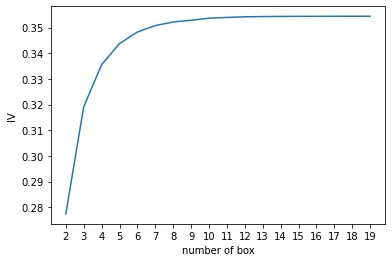

In [20]:
num_bins_ = num_bins.copy()
import scipy
import matplotlib.pyplot as plt

IV = []  # 存储某个特征下分成的不同箱子数对应的IV值
axisx = []  # 存储箱子数
while len(num_bins_) > 2:
    pvs = []
    # 获取 num_bins_两两之间的卡方检验的p值（或卡方值）
    for i in range(len(num_bins_) - 1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i + 1][2:]
        pvs.append(scipy.stats.chi2_contingency([x1, x2])[1])  # 0 返回 chi2 值，1 返回 p 值。
    i = pvs.index(max(pvs))  # p值大意味着两个箱子相似，向后合并，直到合并剩两个为止
    num_bins_[i:i + 2] = [(num_bins_[i][0],
                           num_bins_[i + 1][1],
                           num_bins_[i][2] + num_bins_[i + 1][2],
                           num_bins_[i][3] + num_bins_[i + 1][3])]
    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))
plt.figure()
plt.plot(axisx, IV)
plt.xticks(axisx)
plt.xlabel("number of box")
plt.ylabel("IV")
plt.show()
# 分箱时一般取曲线转折处对应的箱子数

## 3.5 用最佳分箱个数分箱，并验证分箱结果

将合并箱体的部分定义为函数，并实现分箱：

In [21]:
def get_bin(num_bins_, n):
    while len(num_bins_) > n:
        pvs = []
        for i in range(len(num_bins_) - 1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i + 1][2:]
            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins_[i:i + 2] = [(num_bins_[i][0],
                               num_bins_[i + 1][1],
                               num_bins_[i][2] + num_bins_[i + 1][2],
                               num_bins_[i][3] + num_bins_[i + 1][3])]
    return num_bins_  # 进行合并后的各箱子信息


num_bins_ = num_bins.copy()
afterbins = get_bin(num_bins_, 4)  # 20个箱子合并成4个箱子
afterbins

[(21.0, 54.0, 53867, 76252),
 (54.0, 61.0, 15743, 12302),
 (61.0, 74.0, 20344, 7384),
 (74.0, 107.0, 7737, 1379)]

In [22]:
bins_df = get_woe(afterbins)
bins_df

,min,max,count_0,count_1,total,percentage,bad_rate,good%,bad%,woe
0,21.0,54.0,53867,76252,130119,0.667250,0.586017,0.551402,0.783542,-0.351361
1,54.0,61.0,15743,12302,28045,0.143815,0.438652,0.161151,0.126412,0.242798
2,61.0,74.0,20344,7384,27728,0.142189,0.266301,0.208248,0.075876,1.009635
3,74.0,107.0,7737,1379,9116,0.046747,0.151272,0.079199,0.014170,1.720820


## 3.6 将选取最佳分箱个数的过程包装为函数

In [23]:
def graphforbestbin(DF, X, Y, n=5, q=20, graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''

    DF = DF[[X, Y]].copy()

    DF["qcut"], bins = pd.qcut(DF[X], retbins=True, q=q, duplicates="drop")
    coount_y0 = DF.loc[DF[Y] == 0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y] == 1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins, bins[1:], coount_y0, coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2] + num_bins[1][2],
                num_bins[0][3] + num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i - 1:i + 1] = [(
                    num_bins[i - 1][0],
                    num_bins[i][1],
                    num_bins[i - 1][2] + num_bins[i][2],
                    num_bins[i - 1][3] + num_bins[i][3])]
                break
        else:
            break

    def get_woe(num_bins):
        columns = ["min", "max", "count_0", "count_1"]
        df = pd.DataFrame(num_bins, columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0 / df.count_0.sum()
        df["bad%"] = df.count_1 / df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins) - 1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i + 1][2:]
            pv = scipy.stats.chi2_contingency([x1, x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i + 2] = [(
            num_bins[i][0],
            num_bins[i + 1][1],
            num_bins[i][2] + num_bins[i + 1][2],
            num_bins[i][3] + num_bins[i + 1][3])]
        global bins_df
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))

    if graph:
        plt.figure()
        plt.plot(axisx, IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()

    return bins_df  # 形状结构跟上面那个类似

## 3.7 对所有特征进行分箱选择

RevolvingUtilizationOfUnsecuredLines


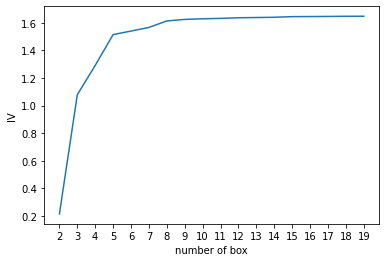

age


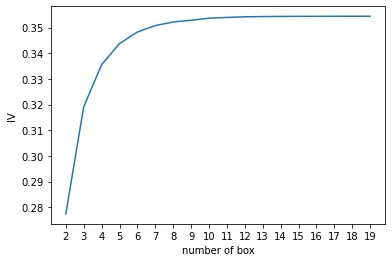

NumberOfTime30-59DaysPastDueNotWorse


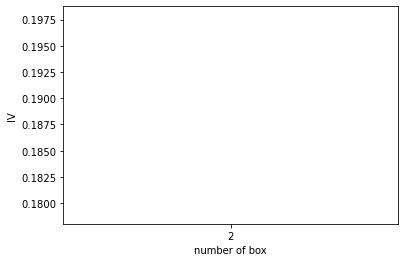

DebtRatio


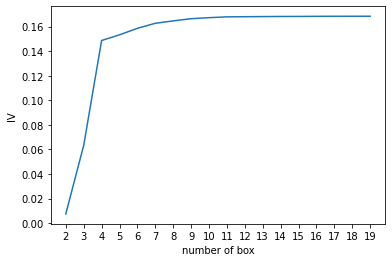

MonthlyIncome


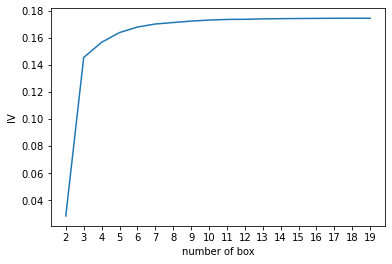

NumberOfOpenCreditLinesAndLoans


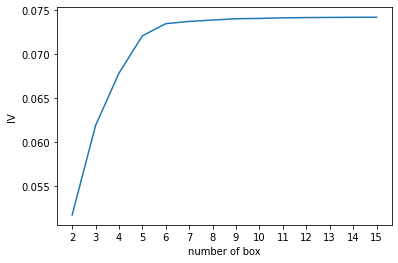

NumberOfTimes90DaysLate


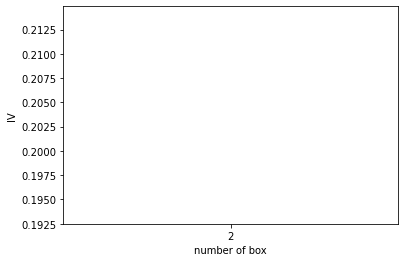

NumberRealEstateLoansOrLines


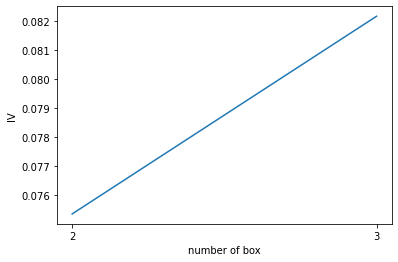

NumberOfTime60-89DaysPastDueNotWorse


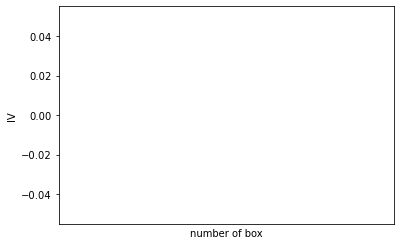

NumberOfDependents


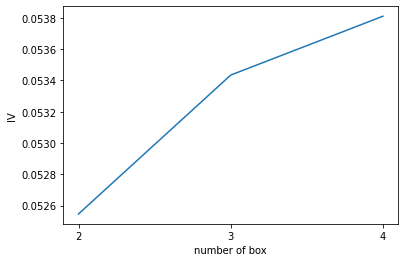

In [24]:
for i in model_data.columns[1:-1]:
    print(i)
    graphforbestbin(model_data, i, "SeriousDlqin2yrs", n=2, q=20, graph=True)

我们发现，不是所有的特征都可以使用这个分箱函数，比如说有的特征，像家人数量，就无法分出20组。于是我们将可以分箱的特征放出来单独分组，不能自动分箱的变量自己观察然后手写（哭哭）：

In [25]:
auto_col_bins = {
    "RevolvingUtilizationOfUnsecuredLines": 6,
    "age": 5,
    "DebtRatio": 4,
    "MonthlyIncome": 3,
    "NumberOfOpenCreditLinesAndLoans": 5}

#不能使用自动分箱的特征。分箱数怎么得出来的，我只能说观察！(describe函数)
hand_bins = {
    "NumberOfTime30-59DaysPastDueNotWorse": [0, 1, 2, 13]
    , "NumberOfTimes90DaysLate": [0, 1, 2, 17]
    , "NumberRealEstateLoansOrLines": [0, 1, 2, 4, 54]
    , "NumberOfTime60-89DaysPastDueNotWorse": [0, 1, 2, 8]
    , "NumberOfDependents": [0, 1, 2, 3]}
#在以后实际业务中，肯定会产生不在我们建模数据中的数据，为了保证区间覆盖使用 np.inf替换最大值，用-np.inf替换最小值
hand_bins = {k: [-np.inf, *v[:-1], np.inf] for k, v in hand_bins.items()}
hand_bins

{'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

接下来对所有特征按照选择的箱体个数和手写的分箱范围进行分箱：

In [26]:
bins_of_col = {}  # 键：特征  值：列表类型，存储各箱子的上下限
# 生成自动分箱的分箱区间和分箱后的 IV 值
for col in auto_col_bins:
    bins_df = graphforbestbin(model_data, col
                              , "SeriousDlqin2yrs"
                              , n=auto_col_bins[col]  #使用字典的性质来取出每个特征所对应的箱的数量
                              , q=20
                              , graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))  # 取出上下限进行合并，升序，数字不重复
    #同理保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0], bins_list[-1] = -np.inf, np.inf
    bins_of_col[col] = bins_list
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.09909037100000001,
  0.2979756206737147,
  0.4653971819632207,
  0.9826108598267972,
  0.9999999,
  inf],
 'age': [-inf, 36.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.0174960197564813,
  0.4015703165293023,
  1.477117033800001,
  inf],
 'MonthlyIncome': [-inf, 0.11, 5598.874669907025, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf]}

In [27]:
#合并手动分箱数据
bins_of_col.update(hand_bins)  # 两个集合合并
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.09909037100000001,
  0.2979756206737147,
  0.4653971819632207,
  0.9826108598267972,
  0.9999999,
  inf],
 'age': [-inf, 36.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.0174960197564813,
  0.4015703165293023,
  1.477117033800001,
  inf],
 'MonthlyIncome': [-inf, 0.11, 5598.874669907025, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

# 4 计算各箱的WOE并映射到数据中

我们现在已经有了我们的箱子，接下来我们要做的是计算各箱的WOE，并且把WOE替换到我们的原始数据model_data中（就是某个数据对应某个箱子，而这个箱子对应相应的WOE值）。因为我们将使用WOE的数据来建模，我们希望获取的是”各个箱”的分类结果，即评分卡上各个评分项目的分类结果。

In [28]:
# 以age为例：
data = model_data.copy()
#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为 pd.cut(数据，以列表表示的分箱间隔)
data = data[["age", "SeriousDlqin2yrs"]].copy()
data["cut"] = pd.cut(data["age"], [-np.inf, 36.0, 54.0, 61.0, 74.0, np.inf])

data.head()

#将数据按分箱结果聚合，并取出其中的标签值
data.groupby("cut")["SeriousDlqin2yrs"].value_counts()

#使用unstack()来将树状结构变成表状结构
data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()

bins_df = data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()
bins_df["woe"] = np.log((bins_df[0] / bins_df[0].sum()) / (bins_df[1] / bins_df[1].sum()))
bins_df  # 注意每一行是age的各个区间（箱子）

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 36.0]",14797,24817,-0.520940
"(36.0, 54.0]",39070,51435,-0.278800
"(54.0, 61.0]",15743,12302,0.242798
"(61.0, 74.0]",20344,7384,1.009635
"(74.0, inf]",7737,1379,1.720820


把以上过程包装成函数：

In [29]:
def get_woe(df, col, y, bins):  # df为全部数据（包括标签和特征），col为某个特征名，y为标签,bins为列表：所有箱子上下限
    df = df[[col, y]].copy()
    df["cut"] = pd.cut(df[col], bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[0] / bins_df[0].sum()) / (bins_df[1] / bins_df[1].sum()))
    return woe


#将所有特征下的各个箱子的WOE存储到字典当中
woeall = {}
for col in bins_of_col:  # bins_of_col别忘了是啥，往前翻
    woeall[col] = get_woe(model_data, col, "SeriousDlqin2yrs", bins_of_col[col])
woeall

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.0991]     2.203044
 (0.0991, 0.298]    0.669276
 (0.298, 0.465]    -0.126959
 (0.465, 0.983]    -1.074049
 (0.983, 1.0]      -0.476140
 (1.0, inf]        -2.037817
 dtype: float64,
 'age': cut
 (-inf, 36.0]   -0.520940
 (36.0, 54.0]   -0.278800
 (54.0, 61.0]    0.242798
 (61.0, 74.0]    1.009635
 (74.0, inf]     1.720820
 dtype: float64,
 'DebtRatio': cut
 (-inf, 0.0175]     1.522395
 (0.0175, 0.402]    0.035256
 (0.402, 1.477]    -0.387114
 (1.477, inf]       0.174369
 dtype: float64,
 'MonthlyIncome': cut
 (-inf, 0.11]        1.455844
 (0.11, 5598.875]   -0.241174
 (5598.875, inf]     0.230569
 dtype: float64,
 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]   -0.847464
 (1.0, 3.0]    -0.333064
 (3.0, 5.0]    -0.054203
 (5.0, 17.0]    0.124762
 (17.0, inf]    0.459929
 dtype: float64,
 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.352305
 (0.0, 1.0]    -0.872557
 (1.0, 2.0]    -1.372660
 (2.0, inf]    -1.54681

接下来，把所有WOE映射到原始数据中：

In [30]:
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据model_data一模一样
model_woe = pd.DataFrame(index=model_data.index)
#将原数据分箱后，按箱的结果把WOE结构用map函数映射到数据中，以'age'为例
# model_woe["age"] = pd.cut(model_data["age"], bins_of_col["age"]).map(woeall["age"])
# model_woe.head()

#对所有特征操作可以写成：
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col], bins_of_col[col]).map(woeall[col])
#将标签补充到数据中
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]
#这就是我们的建模数据了：即把原数据除了标签外的全部数据换成了对应的WOE值
model_woe.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,2.203044,-0.278800,0.035256,-0.241174,-0.054203,0.352305,0.235713,-0.391126,0.125874,0.630305,0
1,0.669276,1.009635,0.035256,-0.241174,-0.054203,0.352305,0.235713,-0.391126,0.125874,0.630305,0
2,-2.037817,-0.278800,-0.387114,-0.241174,-0.054203,-0.872557,-1.751817,-0.391126,-1.759628,-0.475912,1
3,2.203044,1.009635,-0.387114,-0.241174,0.124762,0.352305,0.235713,0.615629,0.125874,0.630305,0
4,-1.074049,-0.278800,-0.387114,0.230569,0.124762,0.352305,0.235713,0.615629,0.125874,-0.584089,1


# 5 建模与模型验证

终于弄完了我们的训练集，接下来我们要处理测试集（也是所有数据换成对应WOE值），在已经有分箱的情况下，测试集的处理就非常简单了，我们只需要将已经计算好的WOE映射到测试集中去就可以了：

In [31]:
#处理测试集
vali_woe = pd.DataFrame(index=vali_data.index)
for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col], bins_of_col[col]).map(woeall[col])
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

vali_X = vali_woe.iloc[:, :-1]
vali_y = vali_woe.iloc[:, -1]

接下来，就可以开始顺利建模了：

In [37]:
X = model_woe.iloc[:, :-1]
y = model_woe.iloc[:, -1]
from sklearn.linear_model import LogisticRegression as LR

lr = LR().fit(X, y)
lr.score(vali_X, vali_y)  # 这么低，我不是很认可，前面花了这么多时间！算了，重在学习

0.7881568871446348

返回的结果一般，我们可以试着使用C和max_iter的学习曲线把逻辑回归的效果调上去。

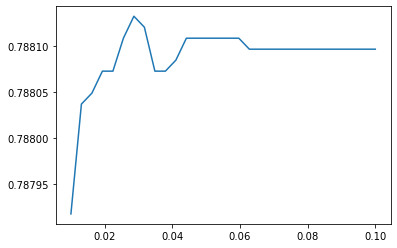

[5]


In [38]:
# c_1 = np.linspace(0.01, 1, 20) # 可以先大的，再逐渐细化
c_2 = np.linspace(0.01, 0.1, 30)
score = []
for i in c_2:
    # 注：C为控制正则化程度的超参数（0,1）之间，正则化强度的倒数，在损失函数前。
    # C越小，模型对损失函数的惩罚越重，正则化的效力越强，参数会逐渐被压缩得越来越小
    lr = LR(solver='liblinear', C=i).fit(X, y)
    score.append(lr.score(vali_X, vali_y))
plt.figure()
plt.plot(c_2, score)
plt.show()
print(lr.n_iter_)  # 最大迭代次数

In [39]:
score.index(max(score)), max(score)  # 还不如不设置，故保持默认就行

(6, 0.7881329568297119)

D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


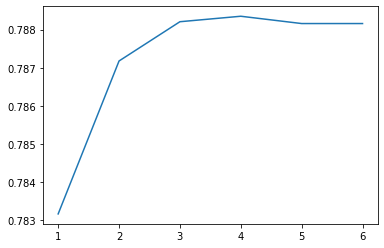

In [40]:
score = []
for i in [1, 2, 3, 4, 5, 6]:
    lr = LR(solver='liblinear', max_iter=i).fit(X, y)
    score.append(lr.score(vali_X, vali_y))
plt.figure()
plt.plot([1, 2, 3, 4, 5, 6], score)
plt.show()

In [41]:
score.index(max(score)), max(score)

(3, 0.7883483296640184)

In [42]:
lr = LR(solver="liblinear", max_iter=4).fit(X, y)
lr.score(vali_X, vali_y)

D:\ANACONDA\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7883483296640184

尽管从准确率来看，我们的模型效果属于一般，但我们可以来看看ROC曲线上的结果。

**模型的效果评估一般是使用ROC曲线下方面积AUC**。

为什么使用AUC，而不是准确率？因为模型预测的是概率，判断最终是好坏，还需要引入阈值(大于阈值，判为坏，小于阈值，判断为好)，阈值不同，准确率也不同。而AUC则是所有阈值的准确率的综合评估。

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

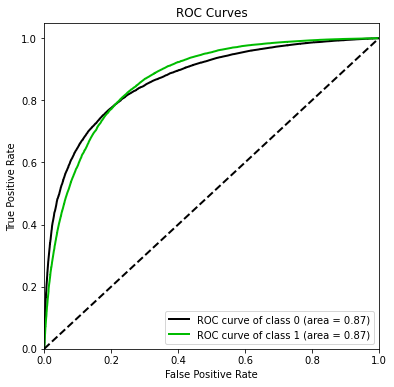

In [43]:
import scikitplot as skplt

vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))
skplt.metrics.plot_roc(vali_y, vali_proba_df, plot_micro=False, figsize=(6, 6), plot_macro=False)
# 曲线下方面积越大，模型效果越好。关于ROC曲线涉及混淆矩阵，相关内容以后再补充。

# 6 制作评分卡

# 截图

In [44]:
B = -20 / np.log(2)
A = 600 - B * np.log(1 / 60)
B, A

(-28.85390081777927, 481.8621880878296)

有了A和B，分数就很容易得到了。其中不受评分卡中各特征影响的基础分BaseScore，就是将模型中的截距部分提出来与A结合；而与特征有关的分数FeatureScore，就是将各个特征对应分箱的分数累积求和。**总分数就等于BaseScore+FeatureScore**。

In [45]:
base_score = A + B * lr.intercept_
base_score

array([482.01291709])

In [47]:
# age这一列的特征分数
score_age = B * (lr.coef_[0][1] * woeall["age"])
score_age

cut
(-inf, 36.0]    -4.092288
(36.0, 54.0]    -2.190134
(54.0, 61.0]     1.907321
(61.0, 74.0]     7.931268
(74.0, inf]     13.518039
dtype: float64

我们可以通过循环，将所有特征的评分卡内容全部一次性写往一个本地文件ScoreData.csv：


In [49]:
#之后使用循环，每次生成一组score_age类似的分档和分数，不断写入文件之中
with open('./评分卡.csv', "w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i, col in enumerate(X.columns):
    score = B * lr.coef_[0][i] * woeall[col]
    score.name = "Score"
    score.index.name = col
    score.to_csv('./评分卡.csv', header=True, mode="a")